# Small Nimmt 6 tournament

In [1]:
import numpy as np
import logging
import sys
import torch
import pickle
from tqdm import tqdm
from matplotlib import pyplot as plt

sys.path.append("../")

from rl_6_nimmt import Tournament, GameSession
from rl_6_nimmt.agents import Human, DrunkHamster, MaskedReinforceAgent, BatchedReinforceAgent, BatchedACERAgent

logging.basicConfig(format="%(message)s",level=logging.INFO)
for name in logging.root.manager.loggerDict:
    if not "rl_6_nimmt" in name:
        logging.getLogger(name).setLevel(logging.WARNING)


## Agents

In [2]:
agents = {}

for i in range(1):
    agents[f"Batched REINFORCE {i+1}"] = BatchedReinforceAgent(r_factor=0.1)
    agents[f"Batched REINFORCE {i+1}"].train()
    
for i in range(1):
    agents[f"Masked REINFORCE {i+1}"] = MaskedReinforceAgent(r_factor=0.1)
    agents[f"Masked REINFORCE {i+1}"].train()
    
for i in range(2):
    agents[f"Batched ACER {i+1}"] = BatchedACERAgent()
    agents[f"Batched ACER {i+1}"].train()
    
for i in range(1):
    agents[f"Random {i+1}"] = DrunkHamster()
    
baseline_agents = [DrunkHamster()]

merle = Human("Merle")


In [3]:
tournament = Tournament(min_players=2, max_players=2, baseline_agents=baseline_agents)

for name, agent in agents.items():
    tournament.add_player(name, agent)

print(tournament)

Tournament after 0 games:
----------------------------------------------------------------------------------------------------
 Agent                | Games | Tournament score | Tournament wins | Baseline score | Baseline wins 
----------------------------------------------------------------------------------------------------
  Batched REINFORCE 1 |     0 |                - |               - |              - |             - 
   Masked REINFORCE 1 |     0 |                - |               - |              - |             - 
       Batched ACER 1 |     0 |                - |               - |              - |             - 
       Batched ACER 2 |     0 |                - |               - |              - |             - 
             Random 1 |     0 |                - |               - |              - |             - 
----------------------------------------------------------------------------------------------------


## Load existing state (skip when running this for the first time)

In [4]:
# agents, tournament = pickle.load(open("./.tournament.pickle", "rb"))

## Let the games begin

In [5]:
num_games = 100000
block_len = 10000

try:
    tqdm._instances.clear()  # Important after cancelling any step
except:
    pass

while tournament.total_games < num_games:
    for _ in tqdm(range(block_len)):
        tournament.play_game()
    print(tournament)


  0%|          | 2/10000 [00:00<09:13, 18.06it/s]

Tournament after 10000 games:
----------------------------------------------------------------------------------------------------
 Agent                | Games | Tournament score | Tournament wins | Baseline score | Baseline wins 
----------------------------------------------------------------------------------------------------
  Batched REINFORCE 1 |  4085 |            -7.69 |            0.48 |          -7.76 |          0.53 
   Masked REINFORCE 1 |  3958 |            -7.86 |            0.49 |          -7.88 |          0.52 
       Batched ACER 1 |  4000 |            -7.24 |            0.52 |          -7.32 |          0.58 
       Batched ACER 2 |  3964 |            -7.32 |            0.52 |          -7.34 |          0.53 
             Random 1 |  3993 |            -7.98 |            0.49 |          -7.95 |          0.52 
----------------------------------------------------------------------------------------------------


  0%|          | 1/10000 [00:00<26:41,  6.24it/s]

Tournament after 20000 games:
----------------------------------------------------------------------------------------------------
 Agent                | Games | Tournament score | Tournament wins | Baseline score | Baseline wins 
----------------------------------------------------------------------------------------------------
  Batched REINFORCE 1 |  8022 |            -7.99 |            0.46 |          -7.63 |          0.52 
   Masked REINFORCE 1 |  7941 |            -7.99 |            0.48 |          -8.11 |          0.50 
       Batched ACER 1 |  8138 |            -7.22 |            0.54 |          -7.43 |          0.57 
       Batched ACER 2 |  7840 |            -7.08 |            0.55 |          -7.10 |          0.57 
             Random 1 |  8059 |            -8.20 |            0.47 |          -7.97 |          0.53 
----------------------------------------------------------------------------------------------------


  0%|          | 1/10000 [00:00<17:18,  9.63it/s]

Tournament after 30000 games:
----------------------------------------------------------------------------------------------------
 Agent                | Games | Tournament score | Tournament wins | Baseline score | Baseline wins 
----------------------------------------------------------------------------------------------------
  Batched REINFORCE 1 | 11980 |            -8.03 |            0.45 |          -7.65 |          0.51 
   Masked REINFORCE 1 | 11947 |            -8.07 |            0.47 |          -8.02 |          0.51 
       Batched ACER 1 | 12144 |            -7.08 |            0.55 |          -7.23 |          0.59 
       Batched ACER 2 | 11831 |            -6.92 |            0.56 |          -6.84 |          0.59 
             Random 1 | 12098 |            -8.23 |            0.46 |          -7.93 |          0.53 
----------------------------------------------------------------------------------------------------


  0%|          | 2/10000 [00:00<13:27, 12.38it/s]

Tournament after 40000 games:
----------------------------------------------------------------------------------------------------
 Agent                | Games | Tournament score | Tournament wins | Baseline score | Baseline wins 
----------------------------------------------------------------------------------------------------
  Batched REINFORCE 1 | 15950 |            -8.17 |            0.44 |          -7.64 |          0.51 
   Masked REINFORCE 1 | 15916 |            -8.19 |            0.46 |          -8.02 |          0.51 
       Batched ACER 1 | 16180 |            -6.96 |            0.57 |          -7.09 |          0.60 
       Batched ACER 2 | 15904 |            -6.88 |            0.57 |          -6.77 |          0.60 
             Random 1 | 16050 |            -8.29 |            0.46 |          -7.99 |          0.53 
----------------------------------------------------------------------------------------------------


  0%|          | 1/10000 [00:00<20:13,  8.24it/s]

Tournament after 50000 games:
----------------------------------------------------------------------------------------------------
 Agent                | Games | Tournament score | Tournament wins | Baseline score | Baseline wins 
----------------------------------------------------------------------------------------------------
  Batched REINFORCE 1 | 20057 |            -8.26 |            0.43 |          -7.60 |          0.51 
   Masked REINFORCE 1 | 19892 |            -8.24 |            0.45 |          -8.07 |          0.52 
       Batched ACER 1 | 20178 |            -6.80 |            0.59 |          -7.07 |          0.61 
       Batched ACER 2 | 19851 |            -6.86 |            0.57 |          -6.70 |          0.61 
             Random 1 | 20022 |            -8.29 |            0.46 |          -8.00 |          0.52 
----------------------------------------------------------------------------------------------------


  0%|          | 3/10000 [00:00<09:51, 16.90it/s]

Tournament after 60000 games:
----------------------------------------------------------------------------------------------------
 Agent                | Games | Tournament score | Tournament wins | Baseline score | Baseline wins 
----------------------------------------------------------------------------------------------------
  Batched REINFORCE 1 | 24010 |            -8.33 |            0.42 |          -7.58 |          0.51 
   Masked REINFORCE 1 | 23957 |            -8.26 |            0.45 |          -8.07 |          0.52 
       Batched ACER 1 | 24245 |            -6.77 |            0.59 |          -7.07 |          0.60 
       Batched ACER 2 | 23832 |            -6.86 |            0.58 |          -6.79 |          0.60 
             Random 1 | 23956 |            -8.34 |            0.46 |          -8.09 |          0.52 
----------------------------------------------------------------------------------------------------


  0%|          | 2/10000 [00:00<13:17, 12.54it/s]

Tournament after 70000 games:
----------------------------------------------------------------------------------------------------
 Agent                | Games | Tournament score | Tournament wins | Baseline score | Baseline wins 
----------------------------------------------------------------------------------------------------
  Batched REINFORCE 1 | 28025 |            -8.34 |            0.42 |          -7.55 |          0.52 
   Masked REINFORCE 1 | 27963 |            -8.28 |            0.45 |          -8.06 |          0.51 
       Batched ACER 1 | 28200 |            -6.70 |            0.60 |          -6.98 |          0.61 
       Batched ACER 2 | 27836 |            -6.88 |            0.57 |          -6.79 |          0.61 
             Random 1 | 27976 |            -8.33 |            0.46 |          -8.08 |          0.52 
----------------------------------------------------------------------------------------------------


  0%|          | 2/10000 [00:00<09:11, 18.13it/s]

Tournament after 80000 games:
----------------------------------------------------------------------------------------------------
 Agent                | Games | Tournament score | Tournament wins | Baseline score | Baseline wins 
----------------------------------------------------------------------------------------------------
  Batched REINFORCE 1 | 32044 |            -8.37 |            0.42 |          -7.50 |          0.53 
   Masked REINFORCE 1 | 31916 |            -8.28 |            0.45 |          -8.11 |          0.51 
       Batched ACER 1 | 32236 |            -6.67 |            0.60 |          -6.89 |          0.61 
       Batched ACER 2 | 31744 |            -6.83 |            0.58 |          -6.72 |          0.61 
             Random 1 | 32060 |            -8.37 |            0.45 |          -8.09 |          0.52 
----------------------------------------------------------------------------------------------------


  0%|          | 4/10000 [00:00<07:57, 20.94it/s]

Tournament after 90000 games:
----------------------------------------------------------------------------------------------------
 Agent                | Games | Tournament score | Tournament wins | Baseline score | Baseline wins 
----------------------------------------------------------------------------------------------------
  Batched REINFORCE 1 | 36000 |            -8.39 |            0.42 |          -7.52 |          0.53 
   Masked REINFORCE 1 | 35903 |            -8.26 |            0.45 |          -8.17 |          0.51 
       Batched ACER 1 | 36329 |            -6.70 |            0.60 |          -6.92 |          0.61 
       Batched ACER 2 | 35750 |            -6.79 |            0.58 |          -6.70 |          0.61 
             Random 1 | 36018 |            -8.37 |            0.45 |          -8.13 |          0.52 
----------------------------------------------------------------------------------------------------


100%|██████████| 10000/10000 [13:24<00:00, 12.43it/s] 


Tournament after 100000 games:
----------------------------------------------------------------------------------------------------
 Agent                | Games | Tournament score | Tournament wins | Baseline score | Baseline wins 
----------------------------------------------------------------------------------------------------
  Batched REINFORCE 1 | 39951 |            -8.38 |            0.42 |          -7.57 |          0.52 
   Masked REINFORCE 1 | 39917 |            -8.24 |            0.46 |          -8.18 |          0.51 
       Batched ACER 1 | 40277 |            -6.66 |            0.60 |          -6.92 |          0.61 
       Batched ACER 2 | 39771 |            -6.79 |            0.58 |          -6.68 |          0.61 
             Random 1 | 40084 |            -8.36 |            0.45 |          -8.17 |          0.51 
----------------------------------------------------------------------------------------------------


In [6]:
pickle.dump((agents, tournament), open( "./.tournament.pickle", "wb" ))

## Let's see the results

In [7]:
print(tournament)

Tournament after 100000 games:
----------------------------------------------------------------------------------------------------
 Agent                | Games | Tournament score | Tournament wins | Baseline score | Baseline wins 
----------------------------------------------------------------------------------------------------
  Batched REINFORCE 1 | 39951 |            -8.38 |            0.42 |          -7.57 |          0.52 
   Masked REINFORCE 1 | 39917 |            -8.24 |            0.46 |          -8.18 |          0.51 
       Batched ACER 1 | 40277 |            -6.66 |            0.60 |          -6.92 |          0.61 
       Batched ACER 2 | 39771 |            -6.79 |            0.58 |          -6.68 |          0.61 
             Random 1 | 40084 |            -8.36 |            0.45 |          -8.17 |          0.51 
----------------------------------------------------------------------------------------------------


In [8]:
def create_color(name):
    if "Batched REINFORCE" in name:
        return "C0"
    elif "Masked REINFORCE" in name:
        return "C1"
    elif "Batched ACER" in name:
        return "C2"
    elif "Random" in name:
        return "0.6"
    
    
def create_label(name):
    return name[:-2] if "1" in name else None


def plot_running_mean(x, y, n=10, **kwargs):
    cumsum = np.cumsum(np.insert(y, 0, 0))
    running_mean_y = (cumsum[n:] - cumsum[:-n]) / n
    
    cumsum = np.cumsum(np.insert(x, 0, 0))
    running_mean_x = (cumsum[n:] - cumsum[:-n]) / n
    
    plt.plot(running_mean_x, running_mean_y, **kwargs)


In [9]:
labels = [
    "Mean Hornochsen in tournament",
    "Mean Hornochsen vs baseline",
    "Win fraction in tournament",
    "Win fraction vs baseline"
]
quantities = [
    tournament.tournament_scores,
    tournament.baseline_scores,
    tournament.tournament_wins,
    tournament.baseline_wins
]
fns = [lambda x : -x, lambda x : -x, lambda x : x, lambda x : x]
baselines = [False, True, False, True]

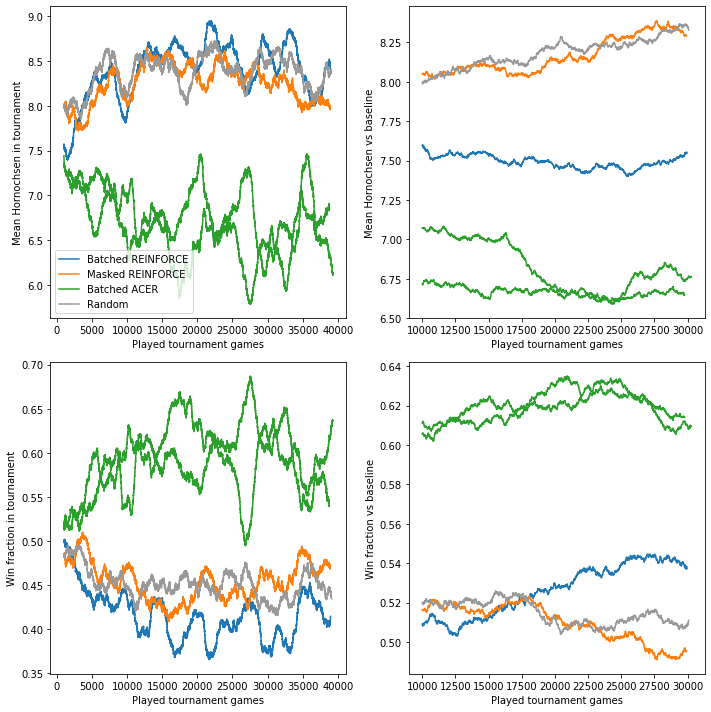

In [15]:
fig = plt.figure(figsize=(10,10))

for panel, (quantity, label, fn, baseline) in enumerate(zip(quantities, labels, fns, baselines)):
    ax = plt.subplot(2,2,panel + 1)
    
    for name in tournament.agents.keys():
        y = np.array(quantity[name])
        x = 10 * np.arange(1, len(y) + 1) if baseline else np.arange(1, len(y) + 1)
        plot_running_mean(x, fn(y), n=2000, label=create_label(name), color=create_color(name))
    
    if panel == 0:
        plt.legend(loc="lower left")
        
    plt.xlabel("Played tournament games")
    plt.ylabel(label)

plt.tight_layout()
plt.show()


## Winner vs Merle

In [16]:
session = GameSession(merle, tournament.winner())

# The DEBUG output shows the moves, which is nice
for name in logging.root.manager.loggerDict:
    if "rl_6_nimmt" in name:
        logging.getLogger(name).setLevel(logging.DEBUG)
        

In [17]:
session.play_game(render=True)

Dealing cards
------------------------------------------------------------------------------------------------------------------------
Board:
   47    _    _    _    _    * 
   99+   _    _    _    _    * 
   66+   _    _    _    _    * 
   11+   _    _    _    _    * 
Players:
  Merle          (player 1):   0 Hornochsen, cards   1   12   30:  36   45.  62   65.  77+  80:  83 
  Batched ACER 1 (player 2):   0 Hornochsen, cards   4    8   10:  13   20:  22+  25.  43   46   55#
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   1  12  30  36  45  62  65  77  80  83. Choose one to play! 12


Batched ACER 1 (player 2) plays card 4
  ...chooses to replace row 1
  ...and gains 1 Hornochsen
Merle          (player 1) plays card 12
------------------------------------------------------------------------------------------------------------------------
Board:
    4    _    _    _    _    * 
   99+   _    _    _    _    * 
   66+   _    _    _    _    * 
   11+  12    _    _    _    * 
Players:
  Merle          (player 1):   0 Hornochsen, cards   1   30:  36   45.  62   65.  77+  80:  83 
  Batched ACER 1 (player 2):   1 Hornochsen, cards   8   10:  13   20:  22+  25.  43   46   55#
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   1  30  36  45  62  65  77  80  83. Choose one to play! 80


Batched ACER 1 (player 2) plays card 10
Merle          (player 1) plays card 80
------------------------------------------------------------------------------------------------------------------------
Board:
    4   10:   _    _    _    * 
   99+   _    _    _    _    * 
   66+  80:   _    _    _    * 
   11+  12    _    _    _    * 
Players:
  Merle          (player 1):   0 Hornochsen, cards   1   30:  36   45.  62   65.  77+  83 
  Batched ACER 1 (player 2):   1 Hornochsen, cards   8   13   20:  22+  25.  43   46   55#
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   1  30  36  45  62  65  77  83. Choose one to play! 83


Batched ACER 1 (player 2) plays card 8
  ...chooses to replace row 1
  ...and gains 4 Hornochsen
Merle          (player 1) plays card 83
------------------------------------------------------------------------------------------------------------------------
Board:
    8    _    _    _    _    * 
   99+   _    _    _    _    * 
   66+  80:  83    _    _    * 
   11+  12    _    _    _    * 
Players:
  Merle          (player 1):   0 Hornochsen, cards   1   30:  36   45.  62   65.  77+
  Batched ACER 1 (player 2):   5 Hornochsen, cards  13   20:  22+  25.  43   46   55#
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   1  30  36  45  62  65  77. Choose one to play! 62


Batched ACER 1 (player 2) plays card 25
Merle          (player 1) plays card 62
------------------------------------------------------------------------------------------------------------------------
Board:
    8    _    _    _    _    * 
   99+   _    _    _    _    * 
   66+  80:  83    _    _    * 
   11+  12   25.  62    _    * 
Players:
  Merle          (player 1):   0 Hornochsen, cards   1   30:  36   45.  65.  77+
  Batched ACER 1 (player 2):   5 Hornochsen, cards  13   20:  22+  43   46   55#
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   1  30  36  45  65  77. Choose one to play! 77


Batched ACER 1 (player 2) plays card 13
Merle          (player 1) plays card 77
------------------------------------------------------------------------------------------------------------------------
Board:
    8   13    _    _    _    * 
   99+   _    _    _    _    * 
   66+  80:  83    _    _    * 
   11+  12   25.  62   77+   * 
Players:
  Merle          (player 1):   0 Hornochsen, cards   1   30:  36   45.  65.
  Batched ACER 1 (player 2):   5 Hornochsen, cards  20:  22+  43   46   55#
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   1  30  36  45  65. Choose one to play! 65


Batched ACER 1 (player 2) plays card 20
Merle          (player 1) plays card 65
------------------------------------------------------------------------------------------------------------------------
Board:
    8   13   20:  65.   _    * 
   99+   _    _    _    _    * 
   66+  80:  83    _    _    * 
   11+  12   25.  62   77+   * 
Players:
  Merle          (player 1):   0 Hornochsen, cards   1   30:  36   45.
  Batched ACER 1 (player 2):   5 Hornochsen, cards  22+  43   46   55#
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   1  30  36  45. Choose one to play! 30


Merle          (player 1) plays card 30
  ...chooses to replace row 2
  ...and gains 5 Hornochsen
Batched ACER 1 (player 2) plays card 55
------------------------------------------------------------------------------------------------------------------------
Board:
    8   13   20:  65.   _    * 
   30:  55#   _    _    _    * 
   66+  80:  83    _    _    * 
   11+  12   25.  62   77+   * 
Players:
  Merle          (player 1):   5 Hornochsen, cards   1   36   45.
  Batched ACER 1 (player 2):   5 Hornochsen, cards  22+  43   46 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   1  36  45. Choose one to play! 45


Merle          (player 1) plays card 45
  ...chooses to replace row 1
  ...and gains 7 Hornochsen
Batched ACER 1 (player 2) plays card 46
------------------------------------------------------------------------------------------------------------------------
Board:
   45.  46    _    _    _    * 
   30:  55#   _    _    _    * 
   66+  80:  83    _    _    * 
   11+  12   25.  62   77+   * 
Players:
  Merle          (player 1):  12 Hornochsen, cards   1   36 
  Batched ACER 1 (player 2):   5 Hornochsen, cards  22+  43 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   1  36. Choose one to play! 1


Merle          (player 1) plays card 1
  ...chooses to replace row 1
  ...and gains 3 Hornochsen
Batched ACER 1 (player 2) plays card 22
------------------------------------------------------------------------------------------------------------------------
Board:
    1   22+   _    _    _    * 
   30:  55#   _    _    _    * 
   66+  80:  83    _    _    * 
   11+  12   25.  62   77+   * 
Players:
  Merle          (player 1):  15 Hornochsen, cards  36 
  Batched ACER 1 (player 2):   5 Hornochsen, cards  43 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  36. Choose one to play! 36


Merle          (player 1) plays card 36
Batched ACER 1 (player 2) plays card 43
------------------------------------------------------------------------------------------------------------------------
Board:
    1   22+  36   43    _    * 
   30:  55#   _    _    _    * 
   66+  80:  83    _    _    * 
   11+  12   25.  62   77+   * 
Players:
  Merle          (player 1):  15 Hornochsen, no cards 
  Batched ACER 1 (player 2):   5 Hornochsen, no cards 
The game is over! Batched ACER 1 (player 2) wins, Merle          (player 1) loses. Congratulations!
------------------------------------------------------------------------------------------------------------------------


In [18]:
session.play_game(render=True)

Dealing cards
------------------------------------------------------------------------------------------------------------------------
Board:
   53    _    _    _    _    * 
   96    _    _    _    _    * 
   52    _    _    _    _    * 
   10:   _    _    _    _    * 
Players:
  Merle          (player 1):   0 Hornochsen, cards   2    4   15.  25.  28   30:  35.  67   73   82 
  Batched ACER 1 (player 2):   0 Hornochsen, cards  18   20:  24   34   51   64   81   85.  93   99+
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   2   4  15  25  28  30  35  67  73  82. Choose one to play! 15


Merle          (player 1) plays card 15
Batched ACER 1 (player 2) plays card 81
------------------------------------------------------------------------------------------------------------------------
Board:
   53   81    _    _    _    * 
   96    _    _    _    _    * 
   52    _    _    _    _    * 
   10:  15.   _    _    _    * 
Players:
  Merle          (player 1):   0 Hornochsen, cards   2    4   25.  28   30:  35.  67   73   82 
  Batched ACER 1 (player 2):   0 Hornochsen, cards  18   20:  24   34   51   64   85.  93   99+
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   2   4  25  28  30  35  67  73  82. Choose one to play! 2


Merle          (player 1) plays card 2
  ...chooses to replace row 2
  ...and gains 1 Hornochsen
Batched ACER 1 (player 2) plays card 34
------------------------------------------------------------------------------------------------------------------------
Board:
   53   81    _    _    _    * 
    2    _    _    _    _    * 
   52    _    _    _    _    * 
   10:  15.  34    _    _    * 
Players:
  Merle          (player 1):   1 Hornochsen, cards   4   25.  28   30:  35.  67   73   82 
  Batched ACER 1 (player 2):   0 Hornochsen, cards  18   20:  24   51   64   85.  93   99+
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:   4  25  28  30  35  67  73  82. Choose one to play! 4


Merle          (player 1) plays card 4
Batched ACER 1 (player 2) plays card 99
------------------------------------------------------------------------------------------------------------------------
Board:
   53   81   99+   _    _    * 
    2    4    _    _    _    * 
   52    _    _    _    _    * 
   10:  15.  34    _    _    * 
Players:
  Merle          (player 1):   1 Hornochsen, cards  25.  28   30:  35.  67   73   82 
  Batched ACER 1 (player 2):   0 Hornochsen, cards  18   20:  24   51   64   85.  93 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  25  28  30  35  67  73  82. Choose one to play! 35


Merle          (player 1) plays card 35
Batched ACER 1 (player 2) plays card 93
------------------------------------------------------------------------------------------------------------------------
Board:
   53   81   99+   _    _    * 
    2    4    _    _    _    * 
   52   93    _    _    _    * 
   10:  15.  34   35.   _    * 
Players:
  Merle          (player 1):   1 Hornochsen, cards  25.  28   30:  67   73   82 
  Batched ACER 1 (player 2):   0 Hornochsen, cards  18   20:  24   51   64   85.
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  25  28  30  67  73  82. Choose one to play! 28


Merle          (player 1) plays card 28
Batched ACER 1 (player 2) plays card 85
------------------------------------------------------------------------------------------------------------------------
Board:
   53   81   99+   _    _    * 
    2    4   28    _    _    * 
   52   93    _    _    _    * 
   10:  15.  34   35.  85.   * 
Players:
  Merle          (player 1):   1 Hornochsen, cards  25.  30:  67   73   82 
  Batched ACER 1 (player 2):   0 Hornochsen, cards  18   20:  24   51   64 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  25  30  67  73  82. Choose one to play! 30


Merle          (player 1) plays card 30
Batched ACER 1 (player 2) plays card 64
------------------------------------------------------------------------------------------------------------------------
Board:
   53   81   99+   _    _    * 
    2    4   28   30:  64    * 
   52   93    _    _    _    * 
   10:  15.  34   35.  85.   * 
Players:
  Merle          (player 1):   1 Hornochsen, cards  25.  67   73   82 
  Batched ACER 1 (player 2):   0 Hornochsen, cards  18   20:  24   51 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  25  67  73  82. Choose one to play! 25


Merle          (player 1) plays card 25
  ...chooses to replace row 3
  ...and gains 2 Hornochsen
Batched ACER 1 (player 2) plays card 51
------------------------------------------------------------------------------------------------------------------------
Board:
   53   81   99+   _    _    * 
    2    4   28   30:  64    * 
   25.  51    _    _    _    * 
   10:  15.  34   35.  85.   * 
Players:
  Merle          (player 1):   3 Hornochsen, cards  67   73   82 
  Batched ACER 1 (player 2):   0 Hornochsen, cards  18   20:  24 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  67  73  82. Choose one to play! 67


Batched ACER 1 (player 2) plays card 18
  ...chooses to replace row 3
  ...and gains 3 Hornochsen
Merle          (player 1) plays card 67
  ...and gains 7 Hornochsen
------------------------------------------------------------------------------------------------------------------------
Board:
   53   81   99+   _    _    * 
   67    _    _    _    _    * 
   18    _    _    _    _    * 
   10:  15.  34   35.  85.   * 
Players:
  Merle          (player 1):  10 Hornochsen, cards  73   82 
  Batched ACER 1 (player 2):   3 Hornochsen, cards  20:  24 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  73  82. Choose one to play! 73


Batched ACER 1 (player 2) plays card 20
Merle          (player 1) plays card 73
------------------------------------------------------------------------------------------------------------------------
Board:
   53   81   99+   _    _    * 
   67   73    _    _    _    * 
   18   20:   _    _    _    * 
   10:  15.  34   35.  85.   * 
Players:
  Merle          (player 1):  10 Hornochsen, cards  82 
  Batched ACER 1 (player 2):   3 Hornochsen, cards  24 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  82. Choose one to play! 82


Batched ACER 1 (player 2) plays card 24
Merle          (player 1) plays card 82
------------------------------------------------------------------------------------------------------------------------
Board:
   53   81   99+   _    _    * 
   67   73   82    _    _    * 
   18   20:  24    _    _    * 
   10:  15.  34   35.  85.   * 
Players:
  Merle          (player 1):  10 Hornochsen, no cards 
  Batched ACER 1 (player 2):   3 Hornochsen, no cards 
The game is over! Batched ACER 1 (player 2) wins, Merle          (player 1) loses. Congratulations!
------------------------------------------------------------------------------------------------------------------------


In [19]:
session.play_game(render=True)

Dealing cards
------------------------------------------------------------------------------------------------------------------------
Board:
   23    _    _    _    _    * 
   37    _    _    _    _    * 
    7    _    _    _    _    * 
   22+   _    _    _    _    * 
Players:
  Merle          (player 1):   0 Hornochsen, cards  11+  18   50:  55#  61   62   66+  76   78   88+
  Batched ACER 1 (player 2):   0 Hornochsen, cards   9   28   39   42   44+  54   59   64   68   91 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  11  18  50  55  61  62  66  76  78  88. Choose one to play! 61


Merle          (player 1) plays card 61
Batched ACER 1 (player 2) plays card 91
------------------------------------------------------------------------------------------------------------------------
Board:
   23    _    _    _    _    * 
   37   61   91    _    _    * 
    7    _    _    _    _    * 
   22+   _    _    _    _    * 
Players:
  Merle          (player 1):   0 Hornochsen, cards  11+  18   50:  55#  62   66+  76   78   88+
  Batched ACER 1 (player 2):   0 Hornochsen, cards   9   28   39   42   44+  54   59   64   68 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  11  18  50  55  62  66  76  78  88. Choose one to play! 62


Merle          (player 1) plays card 62
Batched ACER 1 (player 2) plays card 68
------------------------------------------------------------------------------------------------------------------------
Board:
   23   62   68    _    _    * 
   37   61   91    _    _    * 
    7    _    _    _    _    * 
   22+   _    _    _    _    * 
Players:
  Merle          (player 1):   0 Hornochsen, cards  11+  18   50:  55#  66+  76   78   88+
  Batched ACER 1 (player 2):   0 Hornochsen, cards   9   28   39   42   44+  54   59   64 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  11  18  50  55  66  76  78  88. Choose one to play! 78


Batched ACER 1 (player 2) plays card 54
Merle          (player 1) plays card 78
------------------------------------------------------------------------------------------------------------------------
Board:
   23   62   68   78    _    * 
   37   61   91    _    _    * 
    7    _    _    _    _    * 
   22+  54    _    _    _    * 
Players:
  Merle          (player 1):   0 Hornochsen, cards  11+  18   50:  55#  66+  76   88+
  Batched ACER 1 (player 2):   0 Hornochsen, cards   9   28   39   42   44+  59   64 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  11  18  50  55  66  76  88. Choose one to play! 55


Merle          (player 1) plays card 55
Batched ACER 1 (player 2) plays card 64
------------------------------------------------------------------------------------------------------------------------
Board:
   23   62   68   78    _    * 
   37   61   91    _    _    * 
    7    _    _    _    _    * 
   22+  54   55#  64    _    * 
Players:
  Merle          (player 1):   0 Hornochsen, cards  11+  18   50:  66+  76   88+
  Batched ACER 1 (player 2):   0 Hornochsen, cards   9   28   39   42   44+  59 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  11  18  50  66  76  88. Choose one to play! 76


Batched ACER 1 (player 2) plays card 59
Merle          (player 1) plays card 76
------------------------------------------------------------------------------------------------------------------------
Board:
   23   62   68   78    _    * 
   37   61   91    _    _    * 
    7   59    _    _    _    * 
   22+  54   55#  64   76    * 
Players:
  Merle          (player 1):   0 Hornochsen, cards  11+  18   50:  66+  88+
  Batched ACER 1 (player 2):   0 Hornochsen, cards   9   28   39   42   44+
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  11  18  50  66  88. Choose one to play! 88


Batched ACER 1 (player 2) plays card 39
  ...chooses to replace row 3
  ...and gains 2 Hornochsen
Merle          (player 1) plays card 88
------------------------------------------------------------------------------------------------------------------------
Board:
   23   62   68   78   88+   * 
   37   61   91    _    _    * 
   39    _    _    _    _    * 
   22+  54   55#  64   76    * 
Players:
  Merle          (player 1):   0 Hornochsen, cards  11+  18   50:  66+
  Batched ACER 1 (player 2):   2 Hornochsen, cards   9   28   42   44+
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  11  18  50  66. Choose one to play! 50


Batched ACER 1 (player 2) plays card 9
  ...chooses to replace row 3
  ...and gains 1 Hornochsen
Merle          (player 1) plays card 50
------------------------------------------------------------------------------------------------------------------------
Board:
   23   62   68   78   88+   * 
   37   61   91    _    _    * 
    9   50:   _    _    _    * 
   22+  54   55#  64   76    * 
Players:
  Merle          (player 1):   0 Hornochsen, cards  11+  18   66+
  Batched ACER 1 (player 2):   3 Hornochsen, cards  28   42   44+
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  11  18  66. Choose one to play! 66


Batched ACER 1 (player 2) plays card 44
  ...chooses to replace row 2
  ...and gains 3 Hornochsen
Merle          (player 1) plays card 66
------------------------------------------------------------------------------------------------------------------------
Board:
   23   62   68   78   88+   * 
   44+   _    _    _    _    * 
    9   50:  66+   _    _    * 
   22+  54   55#  64   76    * 
Players:
  Merle          (player 1):   0 Hornochsen, cards  11+  18 
  Batched ACER 1 (player 2):   6 Hornochsen, cards  28   42 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  11  18. Choose one to play! 11


Merle          (player 1) plays card 11
  ...chooses to replace row 2
  ...and gains 5 Hornochsen
Batched ACER 1 (player 2) plays card 28
------------------------------------------------------------------------------------------------------------------------
Board:
   23   62   68   78   88+   * 
   11+  28    _    _    _    * 
    9   50:  66+   _    _    * 
   22+  54   55#  64   76    * 
Players:
  Merle          (player 1):   5 Hornochsen, cards  18 
  Batched ACER 1 (player 2):   6 Hornochsen, cards  42 
------------------------------------------------------------------------------------------------------------------------


It is your turn, Merle! You have the following cards:  18. Choose one to play! 18


Merle          (player 1) plays card 18
  ...chooses to replace row 2
  ...and gains 6 Hornochsen
Batched ACER 1 (player 2) plays card 42
------------------------------------------------------------------------------------------------------------------------
Board:
   23   62   68   78   88+   * 
   18   42    _    _    _    * 
    9   50:  66+   _    _    * 
   22+  54   55#  64   76    * 
Players:
  Merle          (player 1):  11 Hornochsen, no cards 
  Batched ACER 1 (player 2):   6 Hornochsen, no cards 
The game is over! Batched ACER 1 (player 2) wins, Merle          (player 1) loses. Congratulations!
------------------------------------------------------------------------------------------------------------------------
